<a href="https://colab.research.google.com/github/floranuta/GenerativeAI-II-Project/blob/TetianaBogach/Projekt_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -qU "langchain[google-genai]"

In [4]:
import os
from google.colab import userdata

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGSMITH_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

In [5]:
import getpass
from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [6]:
!pip install langchain_huggingface

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [1]:
!pip install langchain-chroma

In [8]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="news_articles_new",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db_new",  # Where to save data locally, remove if not necessary
)

In [9]:
!pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.8 MB/s eta 0:00:00


**Das Ist Erste Teil von Project. RAG system. **

In [80]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://floranuta.github.io/GenerativeAI-II-Project/article.html",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(

        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100)
all_splits = text_splitter.split_documents(docs)

# Print the number of splits to check for content
print(f"Number of splits: {len(all_splits)}")

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Number of splits: 59


In [47]:
response = graph.invoke({"question": "Who is the youngest world chess champion?"})
print(response["context"])
print(response["answer"])

[Document(id='817a11d6-5f61-4437-92af-737571a4790c', metadata={'description': 'A brief description of the page', 'language': 'en', 'source': 'https://floranuta.github.io/GenerativeAI-II-Project/article.html', 'title': 'Document'}, page_content='Document\n\n\n\n\nWelcome to My Website\n\n\nSection 1\n\n\n\n\n\nGukesh Dommaraju becomes youngest world chess champion in 2024 after horrific Ding Liren blunder.\nIndian teenager Gukesh Dommaraju capped a stunning ascent to the pinnacle of chess by dethroning China’s Ding Liren to become the youngest ever world champion on Thursday in Singapore.'), Document(id='569e2558-04d8-4f99-a708-3de15074234a', metadata={'description': 'A brief description of the page', 'language': 'en', 'source': 'https://floranuta.github.io/GenerativeAI-II-Project/article.html', 'title': 'Document'}, page_content='title of grandmaster at the age of 12 and is the third-youngest grandmaster in chess history.'), Document(id='6886e0fe-0fc9-4c89-9fe1-4b753f4aebbf', metadata=

In [48]:
response = graph.invoke({"question": "When had Gukessh become champion?"})
print(response["answer"])

I'm sorry, but the provided text does not mention when Gukesh became champion. It only mentions that he entered the top-five in the FIDE rankings on October 1, 2024.


In [67]:
response = graph.invoke({"question": "How much Gukessh won?"})
print(response["answer"])

Gukesh won $1.35 million, which is also £1.06 million. This was the winner's share of the $2.5 million prize fund. The win also earned him the sport’s most prestigious title.


In [81]:
response = graph.invoke({"question": "Whose age record Gukessh beat?"})
print(response["answer"])

Gukesh beat the age record held by Garry Kasparov. Kasparov was 22 when he beat Anatoly Karpov in 1985. Gukesh broke Kasparov's record by being younger.


In [82]:
response = graph.invoke({"question": "how was Game 2?"})
print(response["answer"])

Game 2 was a quiet draw. Gukesh followed this with a win in Game 3. The context does not provide further details.


**RAG-basierter Frage-Antwort-Chatbot mit Speicherfunktion – ohne Agenten mit Tools**

In [10]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import MessagesState, START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://floranuta.github.io/GenerativeAI-II-Project/article.html",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(

        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100)
all_splits = text_splitter.split_documents(docs)

# Print the number of splits to check for content
print(f"Number of splits: {len(all_splits)}")

# Index chunks
_ = vector_store.add_documents(documents=all_splits)
graph_builder = StateGraph(MessagesState)

Number of splits: 59


In [11]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=3)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [12]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [13]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

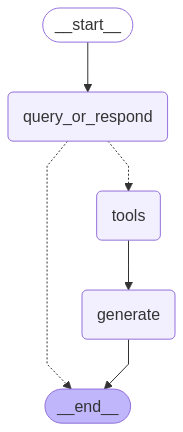

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc988"}}

In [16]:
input_message = "Hello"


for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [17]:
input_message = "Who become the youngest  world chess champion?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Who become the youngest  world chess champion?
================================== Ai Message ==================================
Tool Calls:
  retrieve (b09a3e7c-1702-470f-b40d-88d8ad493f0f)
 Call ID: b09a3e7c-1702-470f-b40d-88d8ad493f0f
  Args:
    query: who is the youngest world chess champion
================================= Tool Message =================================
Name: retrieve

Source: {'description': 'A brief description of the page', 'language': 'en', 'source': 'https://floranuta.github.io/GenerativeAI-II-Project/article.html', 'title': 'Document'}
Content: Document




Welcome to My Website


Section 1





Gukesh Dommaraju becomes youngest world chess champion in November 2024 after horrific Ding Liren blunder.
Indian teenager Gukesh Dommaraju capped a stunning ascent to the pinnacle of chess by dethroning China’s Ding Liren to become the youngest ever world champion on Thursday in Singap

In [18]:
input_message = "Whom has he defeated?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Whom has he defeated?
================================== Ai Message ==================================

Gukesh Dommaraju defeated Ding Liren to become the youngest world chess champion.


In [19]:
input_message = "How much he won?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How much he won?
================================== Ai Message ==================================
Tool Calls:
  retrieve (931c5c49-9b36-423e-b969-c2e2430b6872)
 Call ID: 931c5c49-9b36-423e-b969-c2e2430b6872
  Args:
    query: How much money did Gukesh Dommaraju win for becoming world chess champion?
================================= Tool Message =================================
Name: retrieve

Source: {'description': 'A brief description of the page', 'language': 'en', 'source': 'https://floranuta.github.io/GenerativeAI-II-Project/article.html', 'title': 'Document'}
Content: Gukesh Dommaraju (born 29 May 2006) is an Indian chess grandmaster and the reigning World Chess Champion. A chess prodigy, Gukesh is the youngest undisputed[a] world champion, the youngest player to have surpassed a FIDE rating of 2750, doing so at the age of 17, and the third-youngest to have surpassed 2700 Elo at the age of 16. He 

In [20]:
input_message = "Whose age record he beated?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Whose age record he beated?
================================== Ai Message ==================================

Gukesh Dommaraju broke the record previously held by Garry Kasparov to become the youngest undisputed World Chess Champion.


In [21]:
input_message = "What is exact data of this event?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is exact data of this event?
================================== Ai Message ==================================

I do not have the exact date, but I know it happened in November 2024.


In [23]:
input_message = "What winner said?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What winner said?
================================== Ai Message ==================================
Tool Calls:
  retrieve (c1e1ceb9-4847-49a3-aa5d-1de6bb6efd3e)
 Call ID: c1e1ceb9-4847-49a3-aa5d-1de6bb6efd3e
  Args:
    query: What Gukesh Dommaraju said after winning the world chess championship?
================================= Tool Message =================================
Name: retrieve

Source: {'description': 'A brief description of the page', 'language': 'en', 'source': 'https://floranuta.github.io/GenerativeAI-II-Project/article.html', 'title': 'Document'}
Content: “My journey, it’s been since the time I started playing chess at six and a half, seven [years old],” Gukesh said. “I’ve been dreaming about this moment for more than 10 years. Every chess player wants to experience this moment and very few get the chance. To be one of them is ... I think the only way to explain it is I am living my drea

**RAG-basierter Frage-Antwort-Chatbot  mit Speicherfunktion – ohne Agenten oder Tools**

In [24]:
import bs4
#from langchain_community.document_loaders import WebBaseLoader
#from langchain_text_splitters import RecursiveCharacterTextSplitter
#from langchain_core.vectorstores import Chroma
#from langchain_google_genai import ChatGoogleGenerativeAI
#from langchain_core.embeddings import GoogleGenerativeAIEmbeddings
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory




memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

# 6. Цепочка QA
qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=vector_store.as_retriever(),
    memory=memory,
    verbose=True
)

# 7. Чат
print("🧠 Chatbot is ready. Type 'exit' to quit.")
while True:
    question = input("🧑 You: ")
    if question.lower() in ["exit", "quit"]:
        break
    result = qa_chain.invoke({"question": question})
    print(f"🤖 Bot: {result['answer']}")


<ipython-input-24-c684986fb50f>:13: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


🧠 Chatbot is ready. Type 'exit' to quit.
🧑 You: hello


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
© 2023 Your Name. All rights reserved.

Chess beginnings

Career
Beginnings (2015–2019)

“I was totally in shock when I realized I made a blunder,” Ding said. “His facial expression showed that he was very happy and excited and I realized I made a blunder. It took some time to realize it.”
Human: hello

> Finished chain.

> Finished chain.
🤖 Bot: Hello! How can I help you today?
🧑 You: who is the youngest champion inthe chess in the world? 


> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Cha